Cluster analysis of patron activity in their gaming account.
L1D and L1W are deposits/withdrawals by the patron to/from their gaming account
L2D and L2W are deposits/withdrawals by the patron to their gaming account to place while gaming

Load up the packages for this project

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import itertools
import datetime as dt

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio



Set up some display and format defaults for the data
1. show up to 999 columns
2. set the number of decimal places in floats to 2
3. ignore warnings when slicing a dataframe

In [ ]:
pd.set_option('display.max_columns', 999)
pd.options.display.float_format = '{:20. 2f}'.format
pd.options.mode.chained_assignment = None

Import the data

The df had problems with the float format in the TransactionAmount 
column,there could a problem with some/all of the data
The option to load in the data as all string fixed the issue

df = pd.read_csv("Online_casino_DIB.csv", encoding='utf-8')
df = pd.read_csv("Online_casino_DIB.csv", dtype='str')



In [ ]:
df = pd.read_csv("Online_casino_DIB_A.csv", dtype='str')

df

Create new df to clean up and set up the data

If you want to handle NaN values, you can fill or drop them

Example: filling NaNs with 0
df['TransactionAmount'] = df['TransactionAmount'].fillna(0)  
or
Example: dropping rows with NaNs in 'TransactionAmount'
df.dropna(subset=['TransactionAmount'], inplace=True)  


1. Change the column names to simpler editions
2. Change dtype for ReqTimeUTC to date/time and trim off the time data
3. Change the TransactionAmount into float
4. Check df for bad data entries - none found

In [ ]:
df_raw = df.copy()

df_raw

Troubleshooting tips when a float column won't load correctly:

#problematic_entries = df_raw['TransactionAmount'].apply(pd.to_numeric, 
    errors='coerce').isnull()
#if problematic_entries.any():
    #print("Found problematic entries:")
    #print(df_raw[problematic_entries])

Convert column back to float, with coercing invalid values to NaN

#df_raw['TransactionAmount'] = pd.to_numeric(df_raw['TransactionAmount'], 
    errors='coerce')


In [ ]:
# Convert column to int since values < 1.00 aren't significant

df_raw['TransactionAmount'] = df_raw['TransactionAmount'].astype(int)

In [ ]:
# Convert ReqTimeUTC column to date/time

#df_raw["ReqTimeUTC"] = df_raw["ReqTimeUTC"].astype('datetime64[ns]')

#df_raw["ReqTimeUTC"] = pd.to_datetime(df_raw["ReqTimeUTC"], utc=True)

df_raw["ReqTimeUTC"] = pd.to_datetime(df_raw["ReqTimeUTC"])

In [ ]:
df_raw.head()

In [ ]:
df_raw.dtypes

start here by removing the time stamp

In [ ]:
# Change column names into more usable format

df_raw.rename(columns= {'AccountIdentifier': 'user', 'Status': 'status', 
                    'TransactionType': 'type',
                    'ReqTimeUTC': 'date', 'TransactionAmount': 'amount'},
                    inplace=True)


In [ ]:
df_raw.info()

In [ ]:
# Sweep for NaNs - we have none

nan = df_raw[df_raw.isnull().all(axis=1)].index
nan

In [ ]:
# use REGEX to drop the leading 'customer' for the user column - too clumsy to 

df_raw['user'] = df_raw['user'].str.replace(r'^customer', '',
                                             regex=True)

In [ ]:
df_raw.head()

In [ ]:
df_raw['type'].unique()

In [ ]:
# Map the types into a code and use the mapping in the column

df_raw['type'] = df_raw['type']\
    .map({'LOYALTYCARDDEBIT': 'L2D', 'LOYALTYCARDCREDITCL': 'L1D',
          'LOYALTYCARDCREDIT': 'L2W'})

In [ ]:
df_raw['type'].unique()

Create new df's from df_raw to use to work the data.

Use only the APPROVED L1D data for this first analysis

Good practice to reset the index after extracting data for future work

In [ ]:
df_working = df_raw.copy()

#df_working.head()

In [ ]:
# Filter the DataFrame to get only rows where 'type' is 'L1D'
df_l1d = df_working[df_working['type'] == 'L1D']
df_l1d.reset_index(drop=True, inplace=True)

In [ ]:
# Filter the DataFrame to get only rows where 'status' is 'APPROVED'
df_approved = df_l1d[df_l1d['status'] == 'APPROVED']
df_approved.reset_index(drop=True, inplace=True)

Aggregate the data on on the patron and start to create the RFM features

In [ ]:
df_agg = df_approved.groupby(by='user', as_index=False) \
.agg(
    value = ('amount', 'sum'),
    freq = ('amount', 'nunique'),
    last = ('date', 'max')
)

In [ ]:
df_agg.info()

In [ ]:
df_agg.dtypes


In [ ]:
max_date = df_agg['last'].max()

df_agg['recent'] = (max_date - pd.to_datetime(df_agg['last']))\
    .dt.days



#Extract the date part
df_agg['last_date'] = df_agg['last'].dt.date

#Example max_date for the calculation
max_date = pd.to_datetime('2023-12-09')

#Calculate the number of days between two dates
df_agg['recent'] = (max_date - pd.to_datetime\
    (df_agg['last_date'])).dt.days


In [ ]:
df_agg.head()

In [ ]:
# Plot raw MFR features

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

sns.boxplot(data=df_agg['value'], color='skyblue', ax=ax[0])

sns.boxplot(data=df_agg['freq'], color='orange', ax=ax[1])

sns.boxplot(data=df_agg['recent'], color='salmon', ax=ax[2])



The boxplots show that the extreme outliers in Monetary Value and Frequency.

Remove and save the extremes values for independent consideration if possible

In [ ]:
df_agg.columns

In [ ]:
# Sort out the outliers by removing any anything +/- 1.5*IQR

M_Q1 = df_agg['value'].quantile(0.25)

M_Q3 = df_agg['value'].quantile(0.75)

M_IQR = M_Q3 - M_Q1

M_OLH = M_Q3 + 1.5 * M_IQR
M_OLL = M_Q1 - 1.5 * M_IQR



In [ ]:
df_value_outliers = df_agg[(df_agg['value'] > M_OLH)
                           | (df_agg['value'] < M_OLL)].copy()

In [ ]:
df_value_outliers.info()

In [ ]:
F_Q1 = df_agg['freq'].quantile(0.25)

F_Q3 = df_agg['freq'].quantile(0.75)

F_IQR = F_Q3 - F_Q1

F_OLH = F_Q3 + 1.5 * F_IQR
F_OLL = F_Q1 - 1.5 * F_IQR


In [ ]:
df_freq_outliers = df_agg[(df_agg['freq'] > F_OLH)
                           | (df_agg['freq'] < F_OLL)]\
                            .copy()

In [ ]:
df_freq_outliers.info()

Create new df for data w/ outliers removed

In [ ]:
df_no_outliers = df_agg[(~df_agg.index.isin(df_value_outliers)) &
                        (~df_agg.index.isin(df_freq_outliers))]

In [ ]:
df_no_outliers.info()

Redo the boxplots on the data with the outliers removed to see 
if there is any useful difference

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

sns.boxplot(data=df_no_outliers['value'], color='skyblue',
             ax=ax[0])

sns.boxplot(data=df_no_outliers['freq'], color='orange',
             ax=ax[1])

sns.boxplot(data=df_no_outliers['recent'], color='salmon',
             ax=ax[2])

The effect of removing he outliers is not useful overall, 
so use the df with the most data in it

In [ ]:
# 3-DScatterplot of the aggregated data

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection="3d")                

scatter = ax.scatter(df_agg['value'], df_agg['freq'], 
                     df_agg['recent'])

ax.set_xlabel('Deposit Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3-D Scatterplot of Aggregated Data')

The 3-D Scatter plot shows the data heavily skewed to the right 
meaning the large majority of deposits are small, not frequent and 
strongly variable in recency.

Scale the data and replot 

In [ ]:
scaler = StandardScaler()

scaled_data = scaler.fit_transform(df_agg[['value', 'freq',
                                            'recent']])

scaled_data

In [ ]:
df_scaled_ss = pd.DataFrame(scaled_data, index=df_agg.index,
                            columns= ('value', 'freq', 'recent'))

df_scaled_ss.info()

Replot the data scaled with StandardScaler

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection="3d")                

scatter = ax.scatter(df_scaled_ss['value'], df_scaled_ss['freq'],
                      df_scaled_ss['recent'])

ax.set_xlabel('Deposit Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3-D Scatterplot of Standard Scaled Aggregated Data')

The data is still squashed over on the left side of the plot.
Try a log transformation and plot the transformed data

In [ ]:
selected_columns = ['value', 'freq', 'recent']

df_agg_log = df_agg[selected_columns].copy()

df_agg_log['value'] = np.log1p(df_agg_log['value'])
df_agg_log['freq'] = np.log1p(df_agg_log['freq'])
df_agg_log['recent'] = np.log1p(df_agg_log['recent'])

In [ ]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection="3d")                

scatter = ax.scatter(df_agg_log['value'], df_agg_log['freq'],
                      df_agg_log['recent'])

ax.set_xlabel('Deposit Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3-D Scatterplot of Log Transformed Data')

This a much better distribution of the data

See how clustering this data looks without further scaling

In [ ]:
#First pass to determine optimum number of clusters 
# to use for KMeans

max_k = 12
inertia = []
silhouette_scores = []
k_values = range(2, 12)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, 
                    max_iter=1000)
    cluster_labels = kmeans.fit_predict(df_agg_log)
    sil_score = silhouette_score(df_agg_log, 
                                 cluster_labels)
    silhouette_scores.append(sil_score)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(14, 6))

plt.subplot( 1, 2, 1)
plt.plot(k_values, inertia, marker = 'o')
plt.title("KMeans Inertia for DIfferent Values of k")
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)

plt.subplot( 1, 2, 2)
plt.plot(k_values, silhouette_scores, marker = 'o',
          color='orange')
plt.title("Silhouette Scores for DIfferent Values of k")
plt.xlabel('Silhouette Score')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)

plt.tight_layout()
plt.show()

Silhouette score and inertia both suggest that 
5 clusters will work best for this data

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42, 
                max_iter=1000)

cluster_labels = kmeans.fit_predict(df_agg_log)

cluster_labels

In [ ]:
df_agg_log['clusters'] = cluster_labels

In [ ]:
df_agg_log.info()

3-D Colour Plot the data to id the Clusters

In [ ]:
cluster_colors = {0: '#1f77b4', #Blue
                  1: '#ff7f0e', #Orange
                  2: '#2ca02c', #Green
                  3: '#d62728', #Red
                  4: '#800080', #Purple
                  }

colors = df_agg_log['clusters'].map(cluster_colors)

fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(projection="3d")                

scatter = ax.scatter(df_agg_log['value'],
                    df_agg_log['freq'],
                    df_agg_log['recent'],
                    c=colors,
                    marker='o')

ax.set_xlabel('Deposit Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3-D Scatterplot of Log Transformed Data by Cluster')

The scatter plot shows nicely defined clusters.

Proceed to violin plots to refine the visualization of the features.

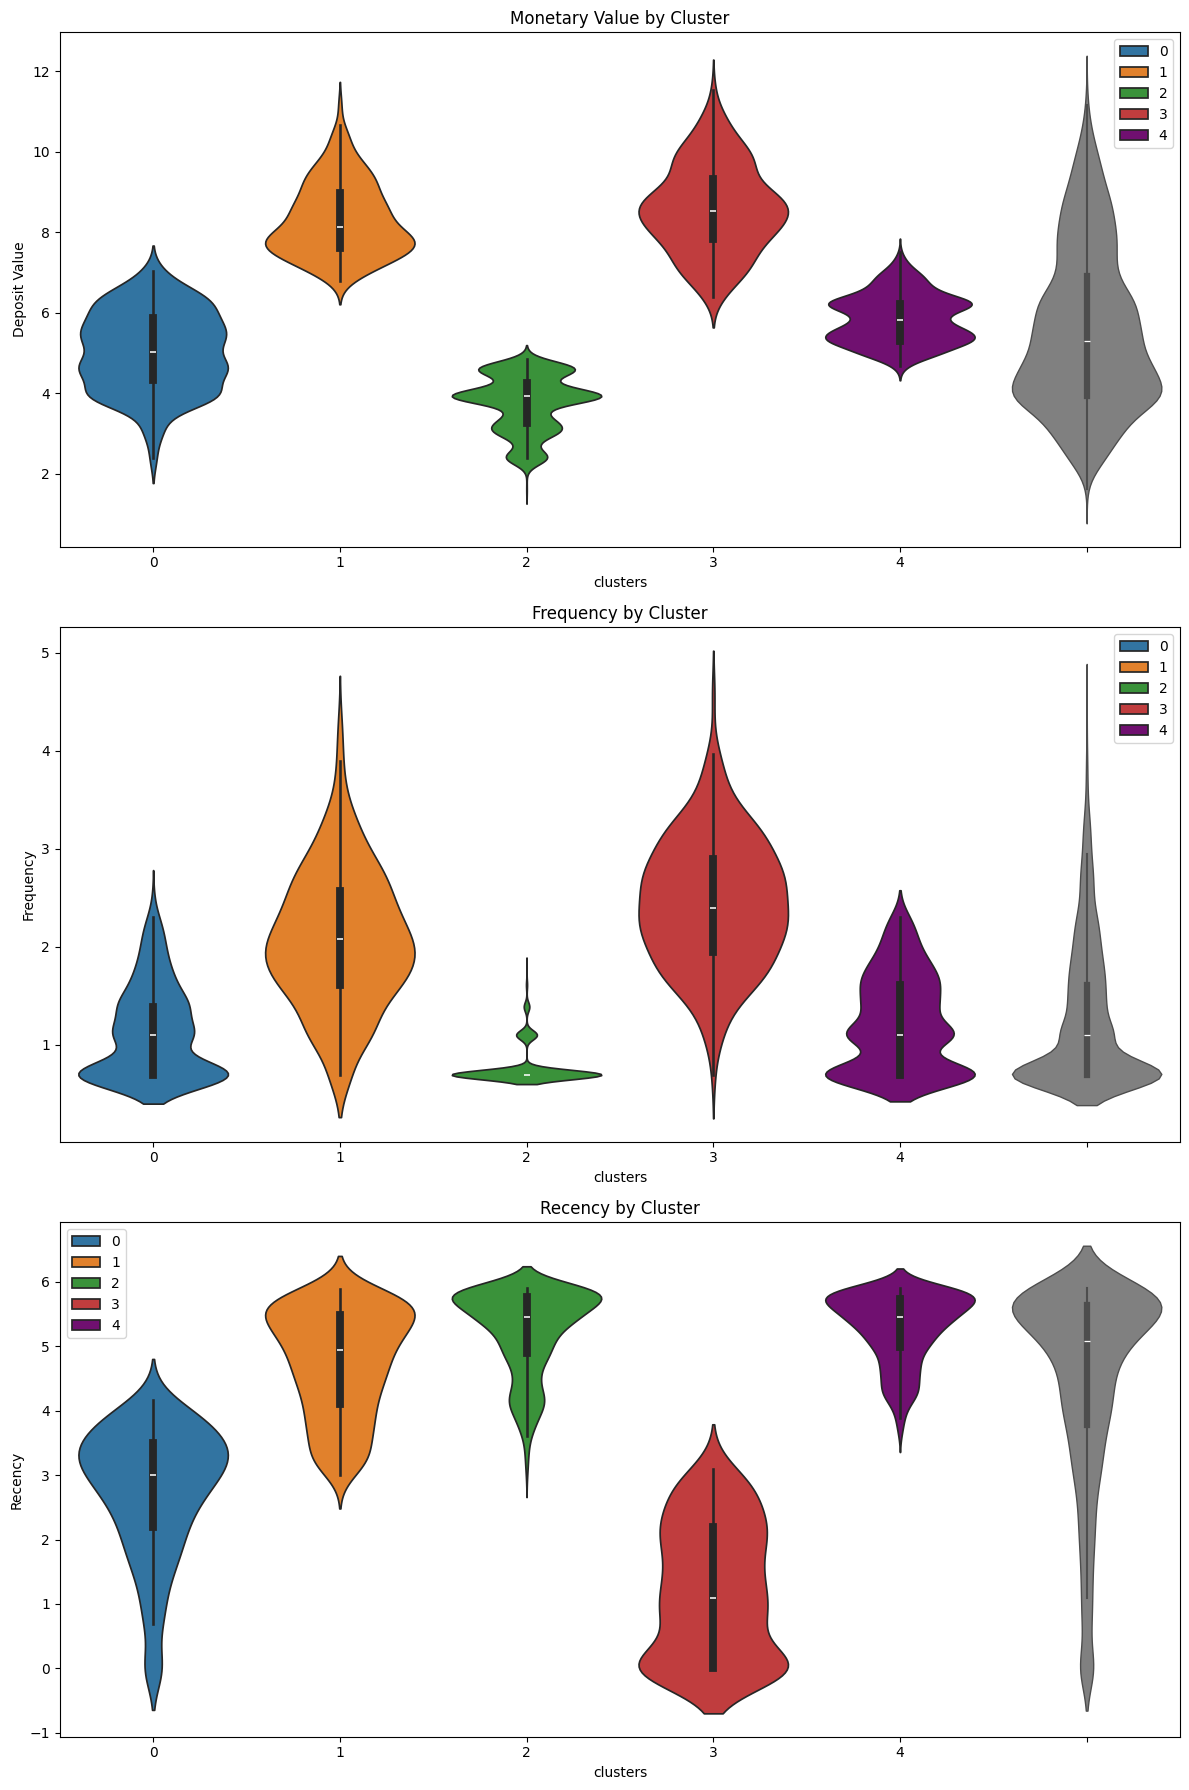

In [51]:
plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.violinplot(x=df_agg_log['clusters'], y=df_agg_log['value'], 
               palette=cluster_colors,
               hue=df_agg_log['clusters'])

sns.violinplot(y=df_agg_log['value'], color='gray', 
               linewidth=1.0)
plt.title('Monetary Value by Cluster')
plt.ylabel('Deposit Value')

plt.subplot(3, 1, 2)

sns.violinplot(x=df_agg_log['clusters'], y=df_agg_log['freq'], 
               palette=cluster_colors,
               hue=df_agg_log['clusters'])

sns.violinplot(y=df_agg_log['freq'], color='gray', 
               linewidth=1.0)
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')

plt.subplot(3, 1, 3)
sns.violinplot(x=df_agg_log['clusters'], y=df_agg_log['recent'], 
               palette=cluster_colors,
               hue=df_agg_log['clusters'])

sns.violinplot(y=df_agg_log['recent'], color='gray', 
               linewidth=1.0)
plt.title('Recency by Cluster')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()